# Assignment 2

***
## Question 2: Triplet networks & one-shot learning (10pt)

In practice 4b.4, we train a Siamese network for one-shot learning task on the Omniglot dataset.  In this assignment, we will work on the same data set with the same task but extend it to triplet networks, we will also compare our model performance under different triplet selection method. The assignment contains the following 4 tasks

### Import packages and mount data
Before everything, we need to import packages and mount data.

*HINT: you could use the dataset in practice 4b.4 directly*

In [0]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout,Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
PATH = os.path.join("drive", "My Drive", "2IMM10 Deep Learning", 
                    "data_DL_practical", "omniglot")

with open(os.path.join(PATH, "omniglot_train.p"), "rb") as f:
    (X_train, c_train) = pickle.load(f)

with open(os.path.join(PATH, "omniglot_test.p"), "rb") as f:
    (X_test, c_test) = pickle.load(f)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("")
print("training alphabets")
print([key for key in c_train.keys()])
print("test alphabets:")
print([key for key in c_test.keys()])

X_train shape: (964, 20, 105, 105)
X_test shape: (659, 20, 105, 105)

training alphabets
['Braille', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Grantha', 'Burmese_(Myanmar)', 'Mkhedruli_(Georgian)', 'Latin', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Malay_(Jawi_-_Arabic)', 'Early_Aramaic', 'Korean', 'Japanese_(hiragana)', 'Armenian', 'Cyrillic', 'Hebrew', 'Syriac_(Estrangelo)', 'Japanese_(katakana)', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'N_Ko', 'Alphabet_of_the_Magi', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Greek', 'Bengali', 'Tagalog', 'Futurama', 'Arcadian', 'Gujarati', 'Asomtavruli_(Georgian)', 'Sanskrit']
test alphabets:
['ULOG', 'Atemayar_Qelisayer', 'Ge_ez', 'Gurmukhi', 'Tengwar', 'Keble', 'Malayalam', 'Oriya', 'Kannada', 'Mongolian', 'Angelic', 'Atlantean', 'Syriac_(Serto)', 'Aurek-Besh', 'Avesta', 'Glagolitic', 'Sylheti', 'Tibetan', 'Manipuri', 'Old_Church_Slavonic_(Cyrillic)']


### Task 2.1: Build  the triplet network (3pt)

We will define a triplet Network for use with the Omniglot dataset. Each branch of the triplet  is a "convnet" model that transforms data to an embeddings space. 

*HINT: you may need "Concatenate" from keras.layer to merge the output layer*

In [0]:
# define a convnet model to transform data to an embeddings space. 
# === COMPLETE CODE BELOW ===
input_shape = (105, 105, 1)

convnet = Sequential(name="convnet")
convnet.add(Conv2D(64, (10,10), activation='relu', 
                   input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))

In [0]:
# define a Triplet network.

# The anchor, positive, negative image are merged together, as the input 
# of the triplet network, then got split to get each one's neural codes.
generated = Input(shape=(3,105, 105, 1), name='input')

anchor  = Lambda(lambda x: x[:,0])(generated)
pos     = Lambda(lambda x: x[:,1])(generated)
neg     = Lambda(lambda x: x[:,2])(generated)
                    
anchor_embedding    = convnet(anchor)
pos_embedding       = convnet(pos)
neg_embedding       = convnet(neg)  

# merge the anchor, positive, negative embedding together, 
# let the merged layer be the output of triplet network

# === COMPLETE CODE BELOW ===
merged_output = Concatenate(name="concatenate")([anchor_embedding, 
                                                 pos_embedding, neg_embedding])

triplet_net = Model(inputs=generated, outputs=merged_output)
triplet_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3, 105, 105, 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 105, 105, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 105, 105, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 105, 105, 1)  0           input[0][0]                      
______________________________________________________________________________________________

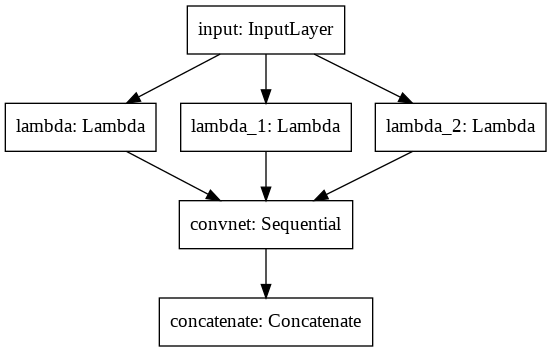

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(triplet_net)

### Task 2.2: Define triplet loss (2pt)

You can find the formula of the triplet loss function in our lecture note. When training our model, make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. 

*HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate, you can also play with the margin value to get better performance*

In [0]:
import tensorflow as tf

# Notice that the ground truth variable is not used for loss calculation. 
# It is used as a function argument to by-pass some Keras functionality.
# This is because the network structure already implies the ground truth 
# for the anchor image with the "positive" image.
def triplet_loss(ground_truth, network_output):
    anchor, positive, negative = tf.split(network_output, 
                                          num_or_size_splits=3, axis=1)
    # === COMPLETE CODE BELOW ===
    margin = 0.2
    # Subtract two embeddings, square the resulting vector
    # and add up all values to form a scalar.
    d_pos = tf.reduce_sum(tf.square(anchor - positive), 1)
    d_neg = tf.reduce_sum(tf.square(anchor - negative), 1)
    loss = tf.reduce_mean(tf.maximum(d_pos - d_neg + margin, 0.0))

    return loss

In [0]:
triplet_net.compile(loss=triplet_loss, optimizer="adam")
unlearned_params = triplet_net.get_weights()

### Task 2.3: Select triplets for training (3pt)

#### Different  selection method

We have two different options for the triplet selection method, and we will compare the model performance under these two methods after building our model.

(1) Random  triplets selection, including the following steps:
* Pick one random class for anchor
* Pick two different random picture for this class, as the anchor and positive images
* Pick another class for Negative, different from anchor_class
* Pick one random picture from the negative class.

(2) Hard triplets selection. For easy implement, for a picked anchor, positive pair, we will choose the hardest negative to form a hard triplet, that means, after picking an anchor, positive image, we will choose the negative image which is nearest from anchor image from a negative class, ie: "- d(a,n)"  can get the maximum value. The whole process including the following steps:
* Pick one random class for anchor
* Pick two different random picture for this class, as an anchor and positive images
* Pick another class for negative, different from anchor_class
* Pick one hardest picture from the negative class.

*HINT: when picking the hardest negative, you may need the model.predict to get the embedding of images, the calculate the distances*

In [0]:
print(triplet_net.get_layer("convnet").get_input_at(0))

Tensor("conv2d_input:0", shape=(None, 105, 105, 1), dtype=float32)


In [0]:
def get_embedding_model(triplet_net):
    embedding_model = Model(inputs=triplet_net.get_layer("convnet")
    .get_input_at(0), outputs=triplet_net.get_layer("convnet").get_output_at(0))
    return embedding_model

In [0]:
def get_negative_class(n_classes, anchor_class):
    # Get random negative class.
    negative_class = np.random.randint(0, n_classes)
    # Get a new random negative class if the same class as the anchor is chosen.
    while negative_class == anchor_class:
        negative_class = np.random.randint(0, n_classes)
    
    return negative_class

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

# Notice that the returned  1 * np.zeros(batch_size) is to by-pass some Keras 
# functionality, corresponding to ground_truth in tripletloss
# We use a variable hard_selection to control which method we are going to use. 
# If we set hard_selection == False, we will select triplets random. 
# If we set the variable hard_selection == True, we will select hard triplets.

# === COMPLETE CODE BELOW === 
def get_batch(X, batch_size=64, hard_selection=False, model=None):

    if hard_selection:
        embedding_model = get_embedding_model(model)

    while True:
        n_classes, n_examples, w, h = X.shape
        # initialize result
        triplets=[]

        for i in range(batch_size):
            triplet = [[],[],[]]
            #Pick one random class for anchor
            anchor_class = np.random.randint(0, n_classes)

            #Pick two different random pics for this class => idx_A and idx_P
            [idx_A, idx_P] = np.random.choice(n_examples, size=2, replace=False)

            #Pick another class for negative, different from anchor_class
            # === COMPLETE CODE BELOW === 
            negative_class = get_negative_class(n_classes, anchor_class)

            if not hard_selection:
                #Pick a random pic from this negative class => N
                # === COMPLETE CODE BELOW ===   
                idx_N = np.random.choice(n_examples, size=1)
            else:
                #Pick a hardest pic from this negative class => N
                # === COMPLETE CODE BELOW ===   
                anchor_embedding = embedding_model.predict(
                    X[anchor_class, idx_A].reshape(1, w, h, 1))
                negative_embedding = embedding_model.predict(
                    X[negative_class].reshape(n_examples, w, h, 1))

                dist = euclidean_distances(anchor_embedding, negative_embedding)
                idx_N = np.argmin(dist)

            triplet[0] = X[anchor_class][idx_A].reshape(w, h, 1)
            triplet[1] = X[anchor_class][idx_P].reshape(w, h, 1)
            triplet[2]=  X[negative_class][idx_N].reshape(w, h, 1)
            triplets.append(triplet)

        yield np.array(triplets), 1 * np.zeros(batch_size)

### Task 2.4: One-shot learning with different selection method (2pt)

Function "make_oneshot_task" that can randomly setup such a one-shot task from a given test set (if a language is specified, using only classes/characters from that language), i.e. it will generate N pairs of images, where the first image is always the test image, and the second image is one of the N reference images. The pair of images from the same class will have target 1, all other targets are 0.

The function "test_oneshot" will generate a number (k) of such one-shot tasks and evaluate the performance of a given model on these tasks; it reports the percentage of correctly classified test images

In "test_oneshot", you can use embeddings extracted from the triplet network with L2-distance to evaluate one-shot learning. i.e. for a given one-shot task, obtain embeddings for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

*HINT you can re-use some code from practice 4b.4*

In [0]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, 
    for testing N-way one-shot learning."""
    n_classes, n_examples, w, h = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    if language is not None:
        low, high = c[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters"
            .format(language, N))
        categories = np.random.choice(range(low,high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, 1)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

In [0]:
def test_oneshot(model, X, c, N=20, k=250, language=None):
    # === COMPLETE CODE BELOW ===
    n_correct = 0   

    embedding_model = get_embedding_model(model)

    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)

        # All values of embeds are the same since inputs[0] contains the same
        # picture N times.
        embeds = embedding_model.predict(inputs[0])
        preds = embedding_model.predict(inputs[1])
        # Calculate the distance between the reference image's embedding and the
        # support set image's embeddings. 
        distances = [tf.norm(x - y) for x, y in zip(embeds, preds)]
        if tf.argmin(distances) == tf.argmax(targets):
            n_correct += 1

    return (100 * n_correct / k)

With different triplets selecting method (random and hard), we will train our model and evaluate the model by one-shot learning accuracy.

* You need to explicitly state the accuracy under different  triplets selecting method
* When evaluating model with test_oneshot function, you should evaluate on 20 way one-shot task, and set the number (k) of evaluation one-shot tasks to be 250, then calculate the average accuracy

*HINT: After training our model with random selection method, before train model under hard triplets selection, we should re-build our model (re-run the cell in Task 2.1) to initialize our model and prevent re-use the trained model of random selection*

#### Evaluate one-shot learning with  random triplets selection

In [0]:
def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1,
          hard_selection=False):
    model.fit(get_batch(X_train, batch_size, hard_selection=hard_selection,
                        model=model), 
              steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
# hard_selection == False, select triplets randomly
# Train our model and evaluate the model by one-shot learning accuracy.
loops = 10
best_acc = 0

for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # === ADD CODE HERE ===
    train(triplet_net, X_train, hard_selection=False)
    test_acc = test_oneshot(triplet_net, X_test, c_test)
    print("Current accuracy: {}".format(test_acc))
    if test_acc >= best_acc:
        best_acc = test_acc
        print("New best accuracy: {}".format(best_acc))

print("Final best accuracy: {}".format(best_acc))

=== Training loop 1 ===
100/100 [==============================] - 36s 359ms/step - loss: 24.2854
Current accuracy: 48.0
New best accuracy: 48.0
=== Training loop 2 ===
100/100 [==============================] - 36s 361ms/step - loss: 23.4234
Current accuracy: 58.0
New best accuracy: 58.0
=== Training loop 3 ===
100/100 [==============================] - 36s 356ms/step - loss: 22.3636
Current accuracy: 62.0
New best accuracy: 62.0
=== Training loop 4 ===
100/100 [==============================] - 36s 355ms/step - loss: 22.3798
Current accuracy: 66.4
New best accuracy: 66.4
=== Training loop 5 ===
100/100 [==============================] - 35s 355ms/step - loss: 22.5035
Current accuracy: 63.6
=== Training loop 6 ===
100/100 [==============================] - 35s 355ms/step - loss: 22.4180
Current accuracy: 64.0
=== Training loop 7 ===
100/100 [==============================] - 35s 354ms/step - loss: 21.5739
Current accuracy: 62.4
=== Training loop 8 ===
100/100 [========================

In [0]:
# Reset the weights
triplet_net.set_weights(unlearned_params)

#### Evaluate one-shot learning with  hard triplets selection

In [0]:
# hard_selection == True, select hard triplets
# Train our model and evaluate the model by one-shot learning accuracy.
loops = 10
best_acc = 0

for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # === ADD CODE HERE ===
    train(triplet_net, X_train, hard_selection=True)
    test_acc = test_oneshot(triplet_net, X_test, c_test)
    print("Current accuracy: {}".format(test_acc))
    if test_acc >= best_acc:
        best_acc = test_acc
        print("New best accuracy: {}".format(best_acc))

print("Final best accuracy: {}".format(best_acc))

=== Training loop 1 ===
100/100 [==============================] - 655s 7s/step - loss: 45.7904
Current accuracy: 62.8
New best accuracy: 62.8
=== Training loop 2 ===
100/100 [==============================] - 658s 7s/step - loss: 42.1176
Current accuracy: 71.2
New best accuracy: 71.2
=== Training loop 3 ===
100/100 [==============================] - 664s 7s/step - loss: 37.7094
Current accuracy: 73.6
New best accuracy: 73.6
=== Training loop 4 ===
100/100 [==============================] - 650s 7s/step - loss: 37.5147
Current accuracy: 72.4
=== Training loop 5 ===
100/100 [==============================] - 648s 6s/step - loss: 35.2829
Current accuracy: 72.0
=== Training loop 6 ===
100/100 [==============================] - 647s 6s/step - loss: 33.3048
Current accuracy: 70.0
=== Training loop 7 ===
100/100 [==============================] - 681s 7s/step - loss: 33.2560
Current accuracy: 74.0
New best accuracy: 74.0
=== Training loop 8 ===
100/100 [==============================] - 679s

# Task 3 - Peer review (0 pt):
Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member
contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others? You can use the table below to make an overview of how the tasks were divided:

__Luc__: Gerrit did assignment 2.1 and I did assignment 2.2. I think we split the work fairly. We both evaluated eachother's work and improved where needed. For these reasons I think we deserve the same grade.

__Gerrit__: We distributed the tasks evenly. Luc worked on Question 2 and I worked on Question 1. Once, we were both done with our parts we shared the notebooks with each other and discussed the results. Hence, the workload was split up in a fair manner and we both deserve the same grade.